Time series analysis and forecasting of natural gas prices.

In [5]:
# Required imports
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

In [6]:
# Load and preprocess the data
data = pd.read_csv('Nat_Gas.csv')  # Load natural gas prices dataset
data['Dates'] = pd.to_datetime(data['Dates'])  # Convert 'Dates' column to datetime type
data.head()  # Display the first few rows of the dataset

,Dates,Prices
0,2020-10-31,10.1
1,2020-11-30,10.3
2,2020-12-31,11.0
3,2021-01-31,10.9
4,2021-02-28,10.9


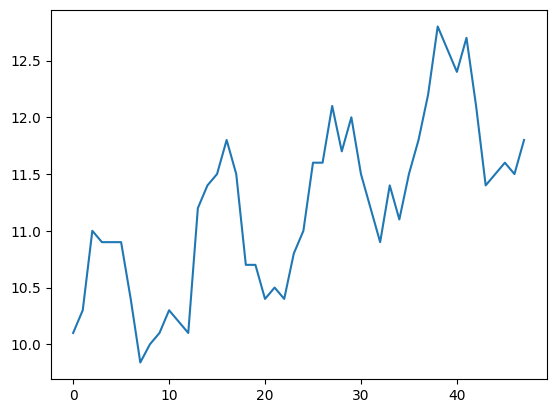

In [7]:
# Set date as the index and plot the time series
df = data.set_index(keys='Dates')  # Set 'Dates' as the index for time series analysis
data['Prices'].plot()  # Plot the prices to visualize trends and seasonality
plt.show()

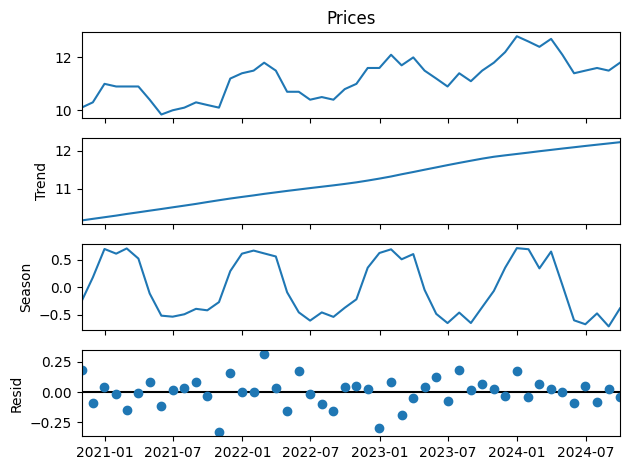

In [8]:
# Seasonal decomposition to identify underlying trends and seasonality
stl = STL(df['Prices'])  # STL decomposition for robust seasonal extraction
res = stl.fit()  # Fit the STL model
res.plot()  # Plot the decomposed components
plt.show()

## SARIMA (Seasonal Autoregressive Integrated Moving Average) model

SARIMA (SARIMA(p,d,q)(P,D,Q)S) = ARIMA (ARIMA(p,d,q)) model on the seasonal and the non-seasonal component of the data

- Non-seasonal orders 
    - p: autoregressive order
    - d: differencing order
    - q: moving average order


- Seasonal orders 
    - P: autoregressive order
    - D: differencing order
    - Q: moving average order
    - S: number of timesteps per cycle

In [9]:
# Optimal SARIMA model configuration using auto_arima
SARIMAXmodel = auto_arima(df, start_p=0, start_q=0,
                          test='adf',  # Use ADF test to find optimal 'd'
                          max_p=3, max_q=3,  # Set max p and q for model complexity
                          m=12,  # Frequency of the series (monthly data)
                          d=None,  # Let model determine 'd'
                          seasonal=True,  # Enable seasonal differencing
                          start_P=0, 
                          D=1,  # Seasonal differencing
                          trace=True,  # Display fitting steps
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)  # Use stepwise algorithm for efficient search
print(SARIMAXmodel.summary())  # Display the fitted model summary

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=36.460, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=21.605, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=25.917, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=34.778, Time=0.03 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=15.104, Time=0.07 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=19.665, Time=0.04 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=8.260, Time=0.29 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=0.75 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(

In [10]:
# Fit SARIMAX model using the identified best parameters
SARIMAXmodel = SARIMAX(df, 
                       order=(2, 1, 0), 
                       seasonal_order=(2, 1, 0, 12))
SARIMAXmodel = SARIMAXmodel.fit()  # Fit the model
forecast = SARIMAXmodel.get_forecast(steps=12)  # Forecast the next 12 months
forecast_df = forecast.conf_int(alpha=0.05)  # 95% confidence intervals
forecast_df['Predictions'] = forecast.predicted_mean  # Mean forecast

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03983D-01    |proj g|=  1.59278D+00


 This problem is unconstrained.



At iterate    5    f= -1.64270D-02    |proj g|=  2.33429D-01

At iterate   10    f= -1.76206D-02    |proj g|=  5.02320D-02

At iterate   15    f= -1.80560D-02    |proj g|=  1.02485D-02

At iterate   20    f= -1.81262D-02    |proj g|=  4.25123D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     28      1     0     0   1.613D-04  -1.813D-02
  F =  -1.8126211997820298E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


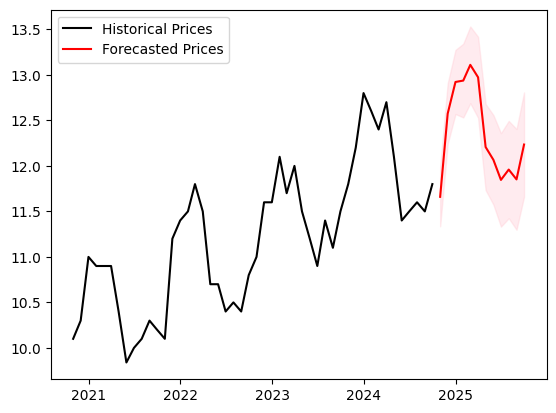

In [11]:
# Plot historical and forecasted prices
plt.plot(df['Prices'], 'k', label='Historical Prices')
plt.plot(forecast_df['Predictions'], 'r', label='Forecasted Prices')
plt.fill_between(forecast_df.index, 
                 forecast_df.iloc[:, 0], 
                 forecast_df.iloc[:, 1], 
                 color='pink', alpha=0.3)  # Confidence interval area
plt.legend(loc = 'upper left')
plt.show()

In [12]:
# Combine historical and forecasted data for analysis
forecast_df.rename(columns={'Predictions': 'Prices'}, inplace=True)
combined_prices = df['Prices'].combine_first(forecast_df['Prices'])
combined_data = pd.DataFrame(combined_prices, columns=['Prices'])
combined_data = combined_data.join(forecast_df[['lower Prices', 'upper Prices']])
upsampled_data = combined_data.resample('D').interpolate(method='polynomial', order=2)  # Increase frequency from monthly to daily
upsampled_data.reset_index().rename(columns={'index':'Dates'}).to_csv('UpsampledData.csv', index=False)  # Save to CSV

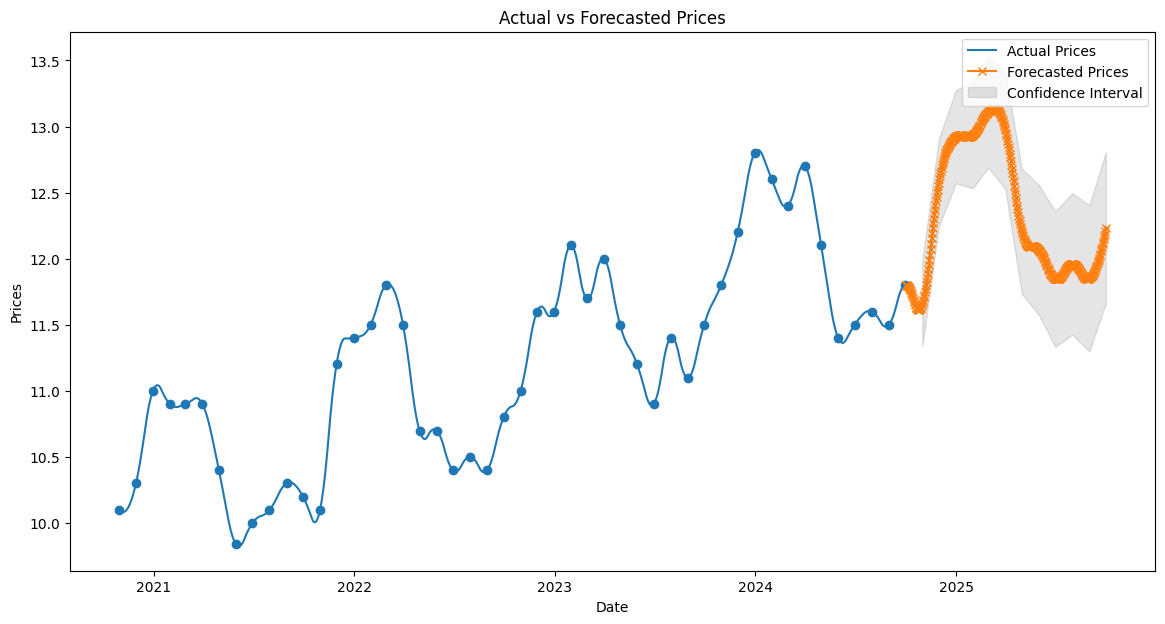

In [13]:
# Final visualization of actual vs forecasted prices
plt.figure(figsize=(14, 7))
plt.scatter(data['Dates'], data['Prices'])
plt.plot(upsampled_data['Prices'], label='Actual Prices')
plt.plot(upsampled_data['Prices'][-365:], label='Forecasted Prices', marker='x')
plt.fill_between(forecast_df.index,
                 forecast_df['lower Prices'],
                 forecast_df['upper Prices'],
                 color='k', alpha=0.1, label='Confidence Interval')
plt.title('Actual vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [14]:
upsampled_data.loc['2025-04-30']['Prices']

12.207137539815012